In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from gmphd import mtt_phd
from utils import *

In [2]:
# Measurement parameters
dim = 2
dt = 1.0
num_steps = 20

birth_prob = 0.2
death_prob = 0.005

det_prob = 0.9
clutter_rate = 3

pos_bounds = (-30, 30)
vel_bounds = (-1, 1)

area = (-100, 100)

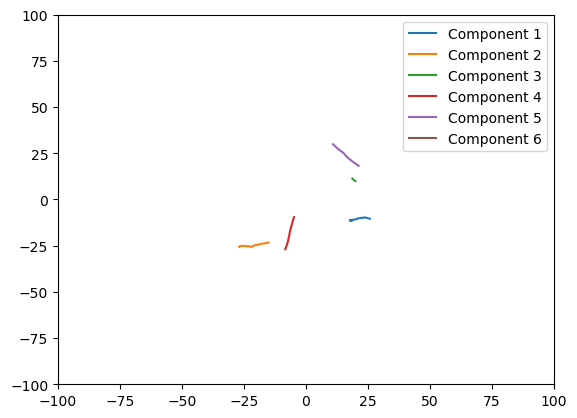

In [3]:
# generate ground truth data
F = create_state_matrix(dt, dim)
Q = np.identity(F.shape[0]) * 0.01

truths = simulate_motion(F, Q, num_steps=num_steps, birth_prob=birth_prob, death_prob=death_prob, pos_bounds=pos_bounds, vel_bounds=vel_bounds)
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    plt.xlim(*area)
    plt.ylim(*area)
plt.legend()

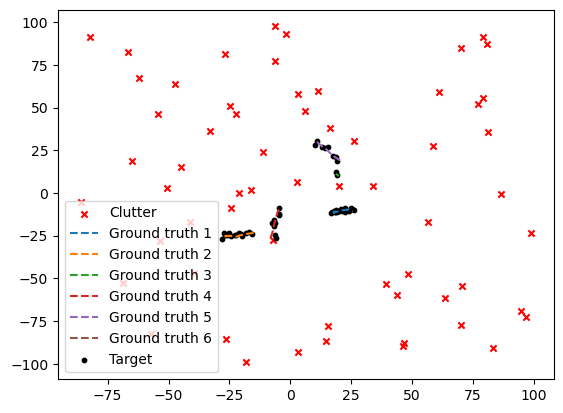

In [4]:
# generate measurements
H = create_measurement_matrix(dim)
R = np.identity(H.shape[0]) * 0.75

all_measurements = simulate_measurement(truths, H, R, num_steps=num_steps, det_prob=det_prob, clutter_rate=clutter_rate, area=area)

component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})

for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='red', marker='x', label='Clutter', s=20)
        else:
            plt.scatter(measurement[0], measurement[1], color='black', label=f'Target', s=10)
    
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    # print(pos)
    plt.plot(*pos[:,:2].T, label=f'Ground truth {i + 1}', linestyle='dashed')

# ignore duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

In [5]:
print("F")
print(F)
print("Q")
print(Q)
print("H")
print(H)
print("R")
print(R)

F
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Q
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]
H
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
R
[[0.75 0.  ]
 [0.   0.75]]


In [6]:
# get initial truths
init_truths = []
for states in truths.values():
    if states[0] is not None:
        init_truths.append(states[0])
    
init_truths = np.array(init_truths)

num_components = len(init_truths)

# assume each component has the same weight
component_weight = 1.0

# the variance of pos and vel
pos_var = 10
vel_var = 5

# each component assumed to start at a random (x, y) ~ U([-100, 100] x [-100, 100])
start_bounds = (-50, 50)

w = [component_weight] * num_components
m = init_truths.copy()
m = np.array(m)
P = np.array([np.diag([pos_var, pos_var, vel_var, vel_var])**2 for _ in range(num_components)])

In [7]:
print("Initial weights:")
print(w)
print("Initial means:")
print(m)
print("Initial covariances:")
print(P)

Initial weights:
[1.0, 1.0, 1.0]
Initial means:
[[ 1.84273250e+01 -1.15737760e+01 -1.47868798e-01  7.19219734e-02]
 [-2.68176634e+01 -2.54613491e+01  2.56758963e-02  7.61546660e-02]
 [ 1.99331024e+01  9.89167171e+00 -7.32222732e-01  7.65995652e-01]]
Initial covariances:
[[[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]]


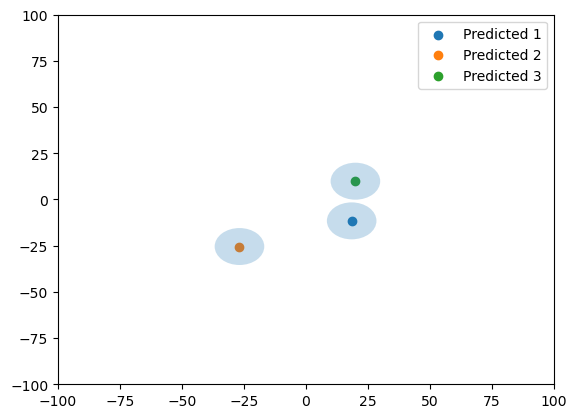

In [8]:
fig, ax = plt.subplots()
for i in range(len(w)):
    pos = m[i][:2]
    cov = P[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(*area)
    ax.set_ylim(*area)
plt.legend()

# Spawning

In [9]:
# initialize the filter
filter = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/np.prod(np.diff(np.vstack([area, area]))),
    merging_threshold = 5.0, # 5
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.4, # 0.60799
    new_birth_weight=0.25, # 0.25,
    spawning = True
)

history = filter.full_PHD_filter_run()

Prev pos: [-26.34385142 -24.85814258], New pos: [-26.31817879 -24.78198796]
Prev pos: [19.18806724  8.43846353], New pos: [18.54890104  9.09393014]
Prev pos: [ 18.71941841 -10.08922662], New pos: [18.50059962 -9.93303095]
Prev pos: [16.44668286 37.68122325], New pos: [15.71461889 38.44703034]
Prev pos: [-21.8954293   45.92891061], New pos: [-22.62765203  46.69490626]
Prev pos: [18.97864701 -7.54805266], New pos: [18.89424609 -7.32985196]
Prev pos: [-25.90715129 -24.46673092], New pos: [-25.88197734 -24.39205706]
Prev pos: [19.29333594 10.50927352], New pos: [18.60016846 11.22888081]
Prev pos: [19.74625494  8.63473915], New pos: [18.8327696   8.18115825]
Prev pos: [16.38073716 37.7502086 ], New pos: [15.64867318 38.51601569]
Prev pos: [-27.05625259 -45.61120944], New pos: [-26.85415421 -51.51104636]
Prev pos: [  9.77934362 -19.70021972], New pos: [  9.56052546 -19.54402404]
Prev pos: [15.46915554  4.14111552], New pos: [14.82998933  4.79658213]
Prev pos: [-20.06276312 -19.1554906 ], New

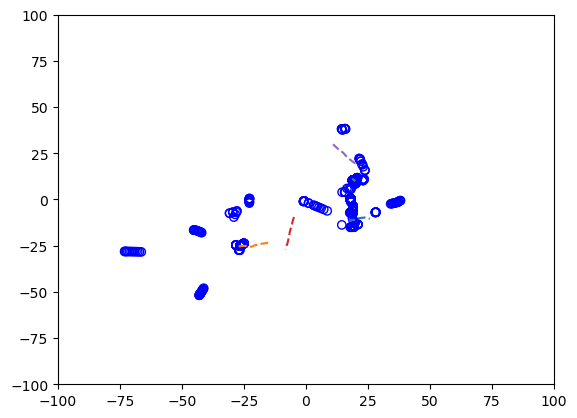

In [10]:
pos = np.array([s[:2] for s in history[-1]])
plt.scatter(*pos[:,:2].T, facecolors='none', edgecolors='blue')
plt.xlim(*area)
plt.ylim(*area)

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, linestyle='dashed')

# No Spawning

In [11]:
# initialize the filter
filter_nospawn = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/np.prod(np.diff(np.vstack([area, area]))),
    merging_threshold = 5.0, # 5
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.607, # 0.60799
    new_birth_weight=0.25, # 0.25,
    spawning = False
)

history = filter_nospawn.full_PHD_filter_run()

Prev pos: [-26.34385142 -24.85814258], New pos: [-26.31817879 -24.78198796]
Prev pos: [19.18806724  8.43846353], New pos: [18.54890104  9.09393014]
Prev pos: [ 18.71941841 -10.08922662], New pos: [18.50059962 -9.93303095]
Prev pos: [16.44668286 37.68122325], New pos: [15.71461889 38.44703034]
Prev pos: [-21.8954293   45.92891061], New pos: [-22.62765203  46.69490626]
Prev pos: [-25.90110984 -24.46092719], New pos: [-25.87593851 -24.3862611 ]
Prev pos: [19.1370369   6.71836644], New pos: [18.53304002  7.33206024]
Prev pos: [ 18.99876835 -10.50446775], New pos: [ 18.99598699 -10.37153975]
Prev pos: [19.74625494  8.63473915], New pos: [18.8327696   8.18115825]
Prev pos: [16.38073716 37.7502086 ], New pos: [15.64867318 38.51601569]
Prev pos: [1.28108829 0.70265199], New pos: [1.28108829 0.70265199]
Prev pos: [-27.40146275 -45.66319138], New pos: [-27.26899369 -49.20450515]
Prev pos: [-5.02184075 18.31273377], New pos: [-5.24065953 18.46892945]
Prev pos: [-23.52244037  28.24576472], New pos

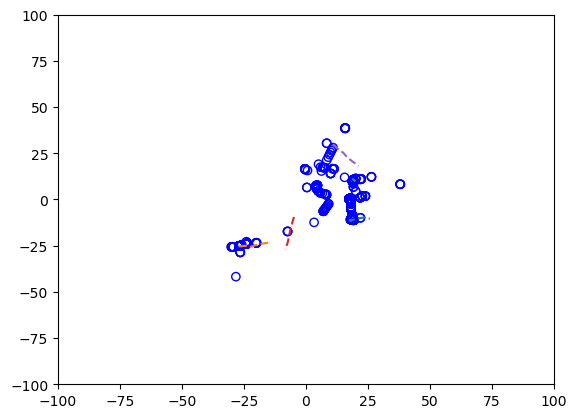

In [12]:
pos = np.array([s[:2] for s in history[-1]])
plt.scatter(*pos[:,:2].T, facecolors='none', edgecolors='blue')
plt.xlim(*area)
plt.ylim(*area)

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, linestyle='dashed')